# Comparison of Last Round AF Subtraction vs. Combined First and Last

**Question:** How should blank images be used for AF subtraction? The last round qunched image can be used, to minimize over subtraction. Or, based on the round, a combination of round zero and last round ("scaled") may be used.

**Samples:** 
- Tissue ID 44290: HER2+/ER+ breast cancer. Section 146 stained with a 8 round cyclic IF protocol, blank images collected at round 0 (after a pre-quenching step) and after R8 stain and quench.

**Method**: AF subtraction performed with two conditions (above), and single cell intensity features were extracted from each image set and analyzed.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import copy
import seaborn as sns
matplotlib.rcParams.update({'font.size': 22})
import numpy as np
import json

# AF Subtraction Scaled vs R8Q Analysis Steps

1. threshold and annotate subtracted data R8Q to get positive ground truth

2. Compare to positve calls when same thresholds are applied to the scaled AF subtracted images

3. calculate F1: TP/TP + 1/2(FP + FN)


## Load Data


In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation'

In [3]:
#based on R8Q subtraction
df_pos = pd.read_csv(
        f'{codedir}/Data/20200826_BC44290-146_ManualPositive.csv',
        index_col=0
    )
#df_pos.head()

In [4]:
# AF subtracted images version
df_pos_scale = pd.read_csv(
        f'{codedir}/Data/20200902_BC44290-146_ManualPositive.csv',
        index_col=0
    )

In [5]:
#channel metadata
df_t = pd.read_csv(f'{codedir}/Metadata/44290-146/metadata_BC44290-146_RoundsCyclesTable_ExposureTimes.csv',
                  index_col=0)

## False Postives

These are eay to calculate across entire tissue, by using a threshold on the AF images (Round 0) to determine bright autofluorescent cells.

In [6]:
#cell types

#define AF
ls_af = ['R0c2_Nuclei','R0c3_Nuclei','R0c4_Nuclei','R0c2_Ring','R0c3_Ring','R0c4_Ring'] 
df_pos['AF'] = df_pos.loc[:,ls_af].sum(axis=1)>=1 


In [53]:
#Whole tissue false positive
ls_marker = df_t[(df_t.colors!='c5') & ~df_t.rounds.isin(['R0','R8Q'])& ~df_t.index.isin(['CD20'])].index
for s_marker in ls_marker:
    if df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')].shape[1] > 0:
        #print(s_marker)
        df_marker = df_pos.loc[:,df_pos.columns.str.contains(f'{s_marker}_')]
        df_scale = df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')]
        df_fp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==True)]
        df_tp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_t.loc[s_marker,'R8Q_FP'] = len(df_fp)
        df_fn = df_scale[(df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_tp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False)]
        df_fp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_pos.loc[:,'AF']==True)]
        df_t.loc[s_marker,'Scaled_FP'] = len(df_fp_scale)
        #these may be fales neg/ or true neg. need to annotate sinlge cells in Napari
        df_t.loc[s_marker,'Scaled_FN'] = len(df_fn)
        df_pos[f'{s_marker}_FalseNegative'] = ((df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[:,'AF']==False))
        f1_baseline = df_tp.sum()[0]/(df_tp.sum()[0] + 0.5*(len(df_fp)))
        f1_scale = df_tp_scale.sum()[0]/(df_tp_scale.sum()[0] + 0.5*(len(df_fp_scale) + len(df_fn)))
        #print(f1_baseline)
        #print(f1_scale)3

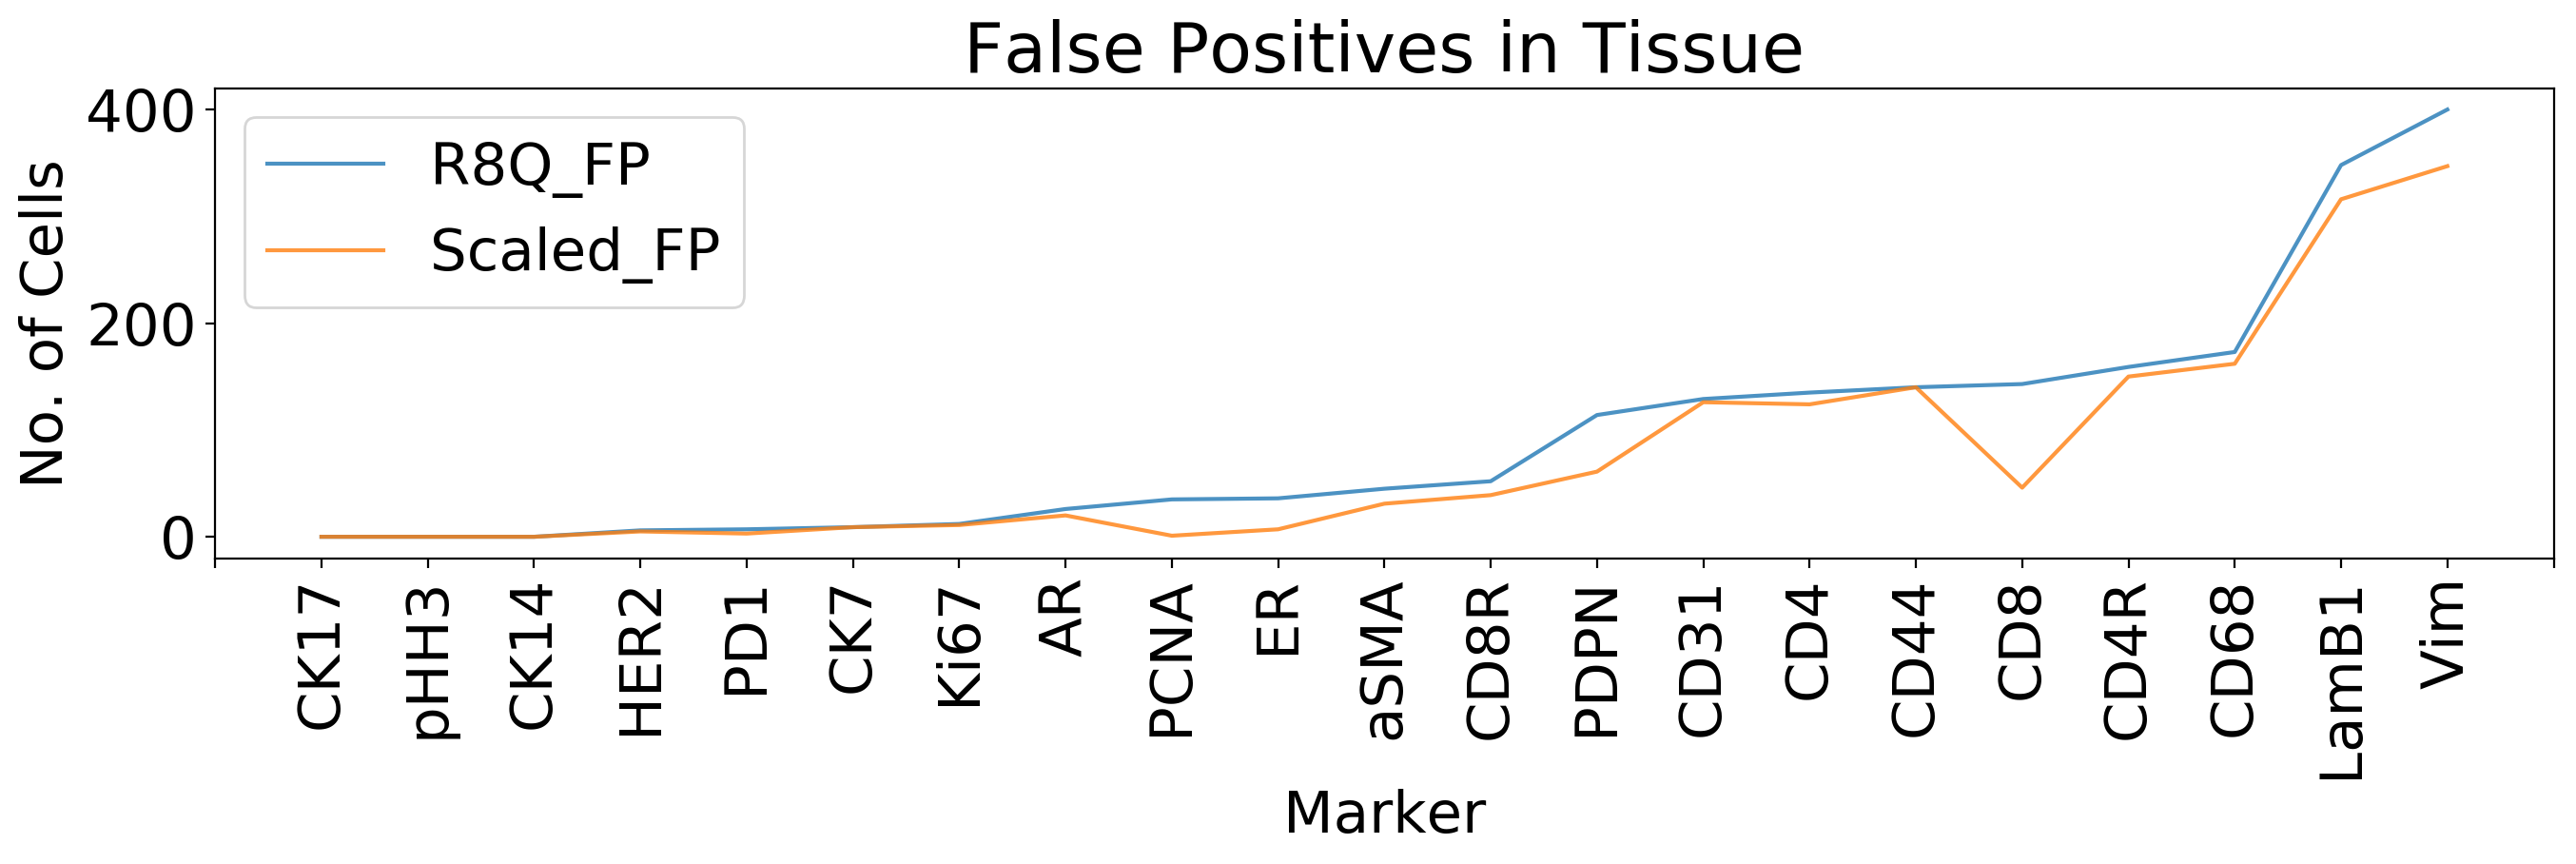

In [54]:
#plot false positives
ls_labels = df_t.loc[ls_marker,:].sort_values('R8Q_FP').loc[:,['R8Q_FP','Scaled_FP']].dropna().index.tolist()
ls_labels.insert(0,'')
fig, ax = plt.subplots(figsize=(14,5),dpi=200)
df_t.loc[ls_marker,:].sort_values('R8Q_FP').loc[:,['R8Q_FP','Scaled_FP']].dropna().plot(ax=ax,rot=90,alpha=0.8)
ax.xaxis.set_major_locator(plt.MaxNLocator(22))
ax.set_xticklabels(ls_labels)
ax.set_title('False Positives in Tissue')
ax.set_ylabel('No. of Cells')
ax.set_xlabel('Marker')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290-146/ScaledvsR8Q_44290_lineplot.png')

# Single Cell Annotation of False Negatives

Calling false negatives requires comparing images and labels in Napari, here. Only 2000 X 2000 pixel ROIs were analyzed

In [41]:
#save potential false negatives for annotation
#df_pos.to_csv(f'{codedir}/Data/20200826_BC44290-146_PositiveNegative.csv')

In [42]:
#load annotated (in Napari)
dd_result = {}
for s_crop in ['x2000y5000','x2000y7000','x1800y9000']:
    with open(f'{codedir}/Data/TrueNegatives_CellIDs_44290-146_scaledAF_{s_crop}.json','r') as f:
        d_result = json.load(f)
    dd_result.update({s_crop:d_result})

In [43]:
d_index = {}
for s_crop in ['x2000y5000','x2000y7000','x1800y9000']:
    idx_x = df_pos[(df_pos.DAPI_X > int(s_crop.split('x')[1].split('y')[0])) & (df_pos.DAPI_X < (2000 + int(s_crop.split('x')[1].split('y')[0])))].index
    idx_y =df_pos[(df_pos.DAPI_Y > int(s_crop.split('y')[1])) & (df_pos.DAPI_Y < (2000 + int(s_crop.split('y')[1])))].index
    index_crop = idx_x.intersection(idx_y)
    d_index.update({s_crop:index_crop})

In [48]:
#calculate F1 in annotated crop
df_result = pd.DataFrame()
ls_marker = df_t[(df_t.colors!='c5') & ~df_t.rounds.isin(['R0','R8Q'])& ~df_t.index.isin(['Vim','CD20','CK14', 'CK17', 'AR', 'PD1', 'pHH3', 'CK7'])].index
for s_marker in ls_marker:
    for s_crop, d_result in dd_result.items():
        index_crop = d_index[s_crop]
        if df_pos_scale.loc[:,df_pos_scale.columns.str.contains(f'{s_marker}_')].shape[1] > 0:
            df_marker = df_pos.loc[index_crop,df_pos.columns.str.contains(f'{s_marker}_')]
            df_scale = df_pos_scale.loc[index_crop,df_pos_scale.columns.str.contains(f'{s_marker}_')]
            df_fp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==True)]
            df_tp = df_marker[(df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_t.loc[s_marker,'R8Q_FP'] = len(df_fp)
            df_fn = df_scale[(df_scale.iloc[:,0]==False) & (df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_tp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_marker.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==False)]
            df_fp_scale = df_scale[(df_scale.iloc[:,0]==True) & (df_pos.loc[index_crop,'AF']==True)]
            df_t.loc[s_marker,'Scaled_FP'] = len(df_fp_scale)
            #these may be fales neg/ or true neg. need to annotate sinlge cells in Napari
            if len(set(d_result.keys()).intersection(set([s_marker.split('_')[0]]))) > 0:
                print(s_marker)
                i_fn = len(d_result[s_marker.split('_')[0]])
            else:
                i_if = 0
            df_t.loc[s_marker,'R8Q_FN'] = i_fn
            df_t.loc[s_marker,'Scaled_FN'] = len(df_fn) - i_fn
            # calculate F1
            f1_baseline = df_tp.sum()[0]/(df_tp.sum()[0] + 0.5*(len(df_fp) + i_fn))
            f1_scale = df_tp_scale.sum()[0]/(df_tp_scale.sum()[0] + 0.5*(len(df_fp_scale) + len(df_fn) - i_fn))
            print(f1_baseline)
            print(f1_scale)
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Baseline'] = f1_baseline
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Scaled'] = f1_scale
            df_result.loc[f"{s_marker.split('_')[0]}_{s_crop}",'Marker'] = s_marker.split('_')[0]


CD8
0.9977608598298253
0.9990999099909991
CD8
0.9901334881021474
0.9970220369267421
CD8
0.9799833194328608
0.9943156974202011
0.9934440559440559
1.0053215077605322
0.9888231426692965
1.0087306917394225
CD4
0.9954207212364052
0.9957007738607051
0.9896907216494846
1.0105263157894737
0.9866666666666667
0.9571428571428572
PCNA
0.9548387096774194
0.966789667896679
0.9831223628691983
1.017467248908297
0.9865771812080537
1.013793103448276
HER2
0.997093023255814
1.0
ER
0.9787234042553191
1.0
0.9615384615384616
1.0101010101010102
ER
0.9801699716713881
0.9853372434017595
0.9995819397993311
1.0
0.9989200863930886
0.9994597514856834
0.9978453435480009
0.9983233532934132
aSMA
0.9302325581395349
0.9230769230769231
0.9787234042553191
1.0
aSMA
0.9621993127147767
0.9812734082397003
CD68
0.997946611909651
1.0
CD68
0.9898580121703854
0.9938398357289527
CD68
0.9662921348314607
0.9712643678160919
0.9887133182844243
1.0115473441108545
0.9896907216494846
1.0105263157894737
0.9900990099009901
1.01010101010101

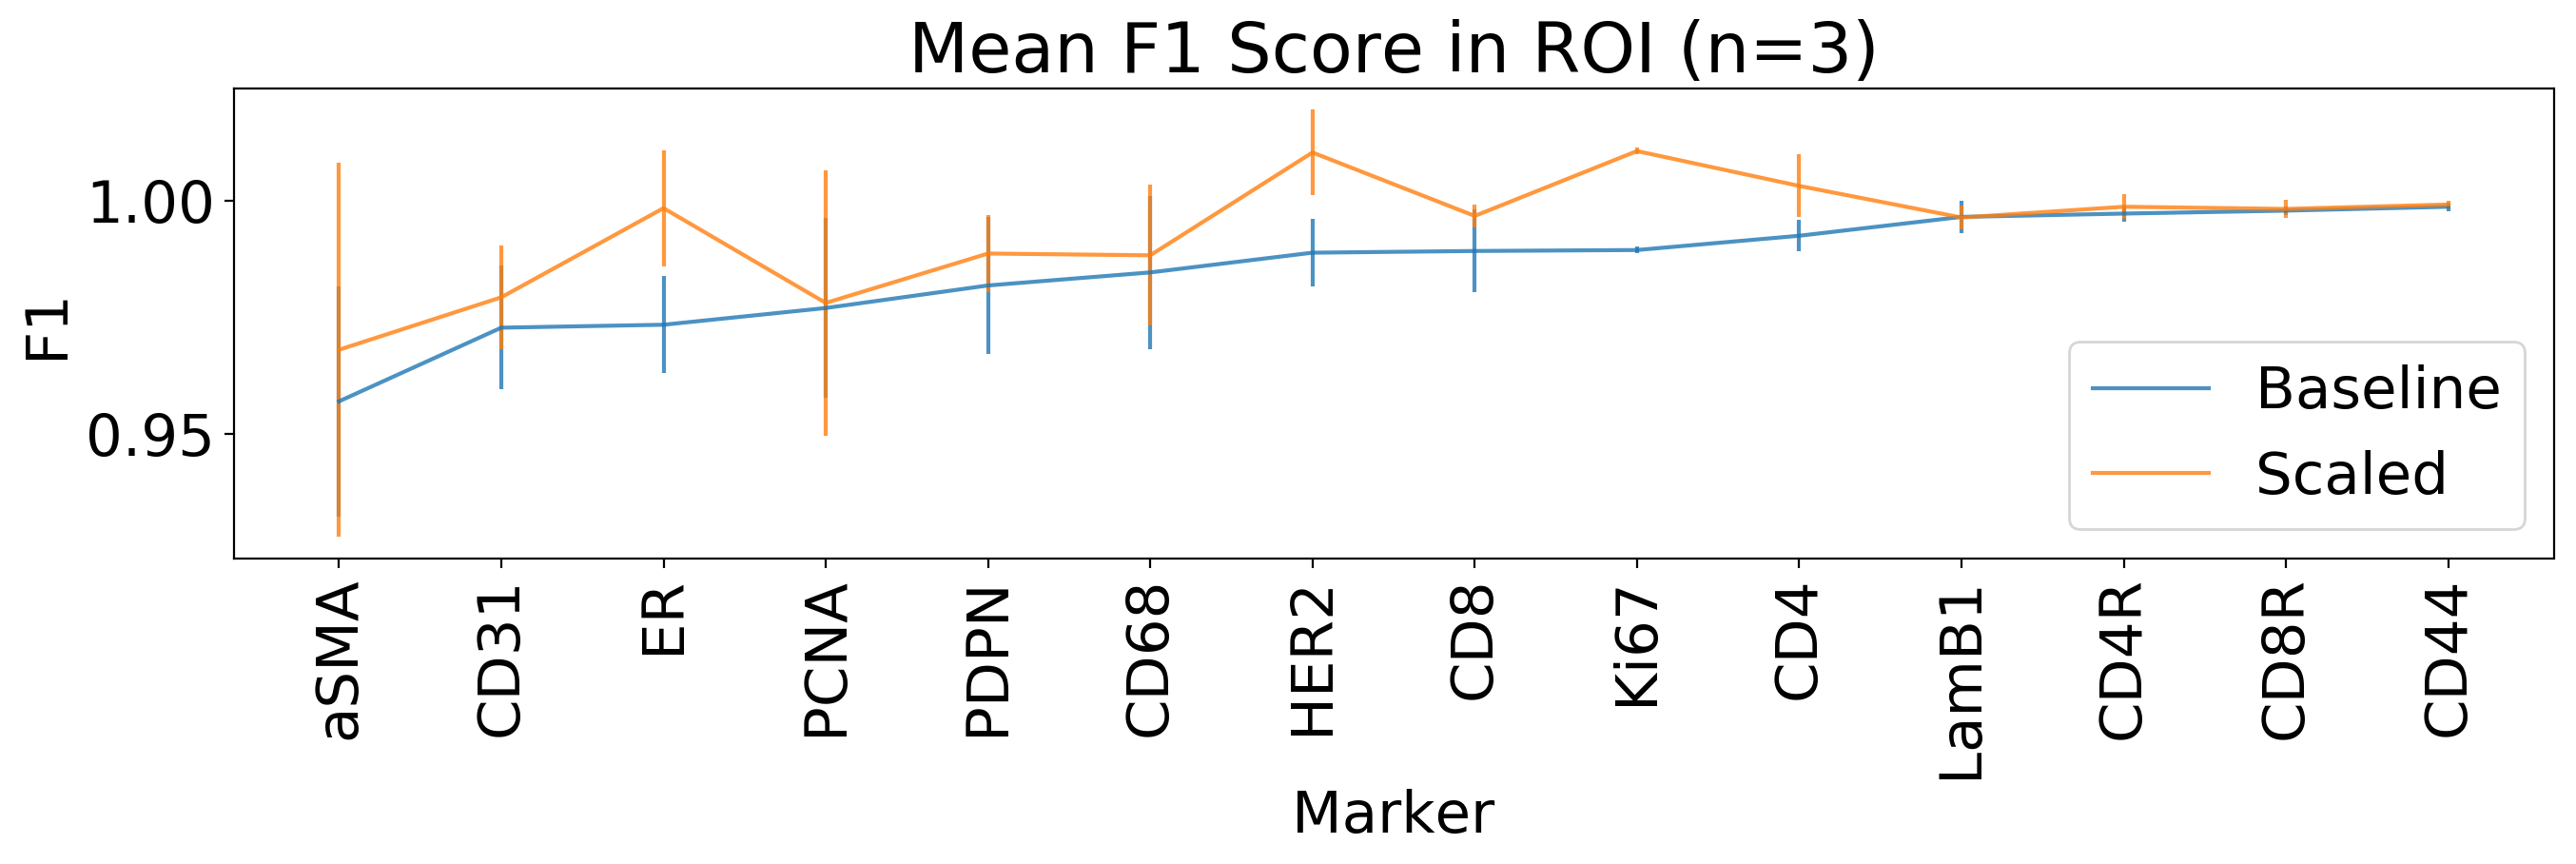

In [52]:
#plot false positives
ls_labels = df_result.groupby('Marker').mean().sort_values('Baseline').index.tolist()
df_std = df_result.groupby('Marker').std().loc[ls_labels]
ls_labels.insert(0,'')
fig, ax = plt.subplots(figsize=(14,5),dpi=200)
df_result.groupby('Marker').mean().sort_values('Baseline').plot(ax=ax,rot=90,alpha=0.8,yerr=df_std)
ax.xaxis.set_major_locator(plt.MaxNLocator(17))
ax.set_xticklabels(ls_labels)
ax.set_title('Mean F1 Score in ROI (n=3)')
ax.set_ylabel('F1')
ax.set_xlabel('Marker')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290-146/ScaledvsR8Q_F1_44290_lineplot.png')


In [56]:
#total cells in 3 rois
i_result = 0
for s_crop, d_result in dd_result.items():
    index_crop = d_index[s_crop]
    i_result = i_result + len(index_crop)
print(i_result)

13891
